## Based on the findings from solar_resource_time_series.ipynb, explore more.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters

plt.style.use("seaborn")
register_matplotlib_converters()

In [4]:
from agrivoltaics_supply_side_management.solar_irradiation.clearsky import get_clearsky

#### Use minute interval data

In [5]:
varrennes_data = pd.read_csv("../../../data/weather_data/solar_irradiance_20140717_var01.csv",
                             header=[0])

In [6]:
varrennes_data

,Date (yyyy-mm-dd),Timestamp (hh:mm:ss.nnn),G1 (W/m2),G2 (W/m2)
0,2014-07-17,03:46:00.000,0,0
1,2014-07-17,03:47:00.000,0,0
2,2014-07-17,03:48:00.000,0,0
3,2014-07-17,03:49:00.000,0,0
4,2014-07-17,03:50:00.000,0,0
...,...,...,...,...
72669,2014-07-17,20:10:00.000,0,0
72670,2014-07-17,20:11:00.000,0,0
72671,2014-07-17,20:12:00.000,0,0
72672,2014-07-17,20:13:00.000,0,0


In [7]:
varrennes_data['Datetime'] = pd.to_datetime(varrennes_data['Date (yyyy-mm-dd)'] 
                                            + ' ' + varrennes_data['Timestamp (hh:mm:ss.nnn)'])

In [8]:
varrennes_data.set_index('Datetime', inplace=True)

In [9]:
varrennes_data.drop(columns=['Date (yyyy-mm-dd)', 'Timestamp (hh:mm:ss.nnn)'], inplace=True)

#### Since this data set contains within minute data when the difference is significant, take only minute interval data

In [10]:
varrennes_data_by_minite = varrennes_data[(varrennes_data.index.second == 0) & (varrennes_data.index.microsecond == 0)]

#### Localize time while taking care of Daylight Saving Time issue.

In [11]:
varrennes_data_by_minite.index = varrennes_data_by_minite.index.tz_localize('Canada/Eastern', 
                                                        ambiguous='NaT', nonexistent='shift_forward')

<AxesSubplot:xlabel='Datetime'>

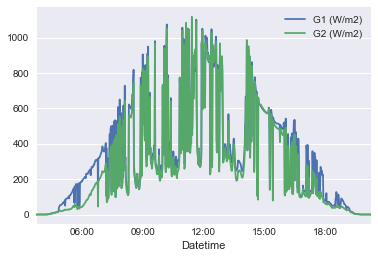

In [12]:
varrennes_data_by_minite.plot()

In [13]:
varrennes_data_ghi_0717 = varrennes_data_by_minite['G1 (W/m2)']

In [38]:
varrennes_data_ghi_0717

Datetime
2014-07-17 03:46:00-04:00    0
2014-07-17 03:47:00-04:00    0
2014-07-17 03:48:00-04:00    0
2014-07-17 03:49:00-04:00    0
2014-07-17 03:50:00-04:00    0
                            ..
2014-07-17 20:10:00-04:00    0
2014-07-17 20:11:00-04:00    0
2014-07-17 20:12:00-04:00    0
2014-07-17 20:13:00-04:00    0
2014-07-17 20:14:00-04:00    0
Name: G1 (W/m2), Length: 989, dtype: int64

<AxesSubplot:xlabel='Datetime'>

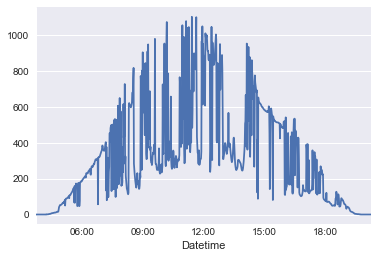

In [14]:
varrennes_data_ghi_0717.plot()

In [15]:
varrennes_clearsky_ghi_0717 = get_clearsky(45.616084, -73.386362, 
                                           'Canada/Eastern', varrennes_data_by_minite.index,
                                           location_name='Varrennes, QC, Canada')['ghi']

In [37]:
varrennes_clearsky_ghi_0717

Datetime
2014-07-17 03:46:00-04:00     0.000000
2014-07-17 03:47:00-04:00     0.000000
2014-07-17 03:48:00-04:00     0.000000
2014-07-17 03:49:00-04:00     0.000000
2014-07-17 03:50:00-04:00     0.000000
                               ...    
2014-07-17 20:10:00-04:00    11.336059
2014-07-17 20:11:00-04:00    10.258105
2014-07-17 20:12:00-04:00     9.238108
2014-07-17 20:13:00-04:00     8.276628
2014-07-17 20:14:00-04:00     7.374060
Name: ghi, Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

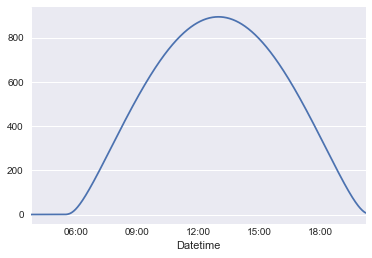

In [16]:
varrennes_clearsky_ghi_0717.plot()

In [23]:
varrennes_data_ghi_residual_0717_1 = varrennes_data_ghi_0717 - varrennes_clearsky_ghi_0717

<AxesSubplot:xlabel='Datetime'>

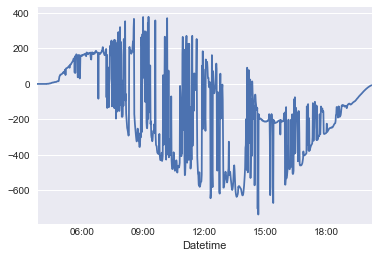

In [24]:
varrennes_data_ghi_residual_0717_1.plot()

#### Take the difference.

In [25]:
varrennes_data_ghi_residual_diff_0717_1 = varrennes_data_ghi_residual_0717_1.diff()

<AxesSubplot:xlabel='Datetime'>

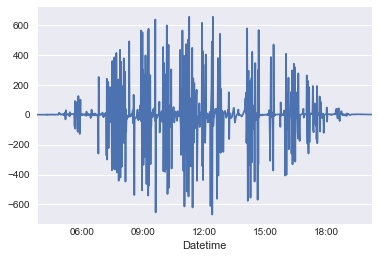

In [26]:
varrennes_data_ghi_residual_diff_0717_1.plot()

#### Since the variance changes, without monotonically increasing or monotonically decreasing, try to divide the original measurement data by clearsky data, instead o subtracting clearsky data from the measurement data.

In [27]:
varrennes_data_ghi_scale_adjusted_0717_1 = varrennes_data_ghi_0717 / varrennes_clearsky_ghi_0717

In [28]:
varrennes_data_ghi_scale_adjusted_0717_1

Datetime
2014-07-17 03:46:00-04:00    NaN
2014-07-17 03:47:00-04:00    NaN
2014-07-17 03:48:00-04:00    NaN
2014-07-17 03:49:00-04:00    NaN
2014-07-17 03:50:00-04:00    NaN
                            ... 
2014-07-17 20:10:00-04:00    0.0
2014-07-17 20:11:00-04:00    0.0
2014-07-17 20:12:00-04:00    0.0
2014-07-17 20:13:00-04:00    0.0
2014-07-17 20:14:00-04:00    0.0
Length: 989, dtype: float64

In [29]:
varrennes_data_ghi_scale_adjusted_0717_1.fillna(0, inplace=True)

In [30]:
varrennes_data_ghi_scale_adjusted_0717_1

Datetime
2014-07-17 03:46:00-04:00    0.0
2014-07-17 03:47:00-04:00    0.0
2014-07-17 03:48:00-04:00    0.0
2014-07-17 03:49:00-04:00    0.0
2014-07-17 03:50:00-04:00    0.0
                            ... 
2014-07-17 20:10:00-04:00    0.0
2014-07-17 20:11:00-04:00    0.0
2014-07-17 20:12:00-04:00    0.0
2014-07-17 20:13:00-04:00    0.0
2014-07-17 20:14:00-04:00    0.0
Length: 989, dtype: float64

<AxesSubplot:xlabel='Datetime'>

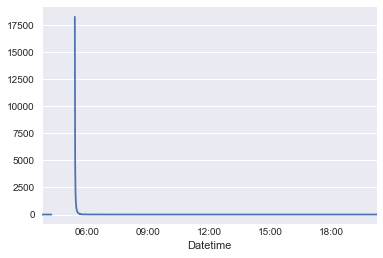

In [31]:
varrennes_data_ghi_scale_adjusted_0717_1.plot()

In [35]:
varrennes_data_ghi_scale_adjusted_0717_2 = varrennes_data_ghi_0717.div(varrennes_clearsky_ghi_0717)

<AxesSubplot:xlabel='Datetime'>

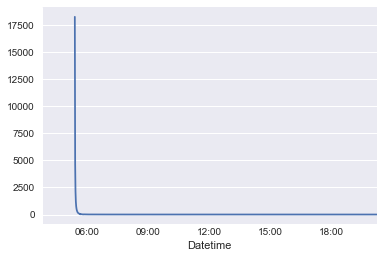

In [36]:
varrennes_data_ghi_scale_adjusted_0717_2.plot()

In [39]:
varrennes_data_ghi_0717[200]

355

In [40]:
varrennes_clearsky_ghi_0717[200]

191.95623435864093

In [41]:
varrennes_data_ghi_0717[200] / varrennes_clearsky_ghi_0717[200]

1.8493798921723827

#### So, the problem is with an outlier. Remove it. 

In [42]:
percentile_25 = varrennes_data_ghi_scale_adjusted_0717_1.quantile(0.25)

In [43]:
percentile_25

0.33986794120001496

In [44]:
percentile_75 = varrennes_data_ghi_scale_adjusted_0717_1.quantile(0.75)

In [45]:
percentile_75

1.2212577248319998

In [46]:
interquartile_range = percentile_75 - percentile_25

In [47]:
interquartile_range

0.8813897836319848

In [48]:
upper_limit = percentile_75 + 1.5 * interquartile_range

In [49]:
upper_limit

2.543342400279977

In [50]:
lower_limit = percentile_25 - 1.5 * interquartile_range

In [51]:
lower_limit

-0.9822167342479624

In [52]:
median = varrennes_data_ghi_scale_adjusted_0717_1.median()

In [53]:
median

0.625784878658687

In [54]:
varrennes_data_ghi_scale_adjusted_0717_1.loc[(varrennes_data_ghi_scale_adjusted_0717_1 < lower_limit) | 
                                             (varrennes_data_ghi_scale_adjusted_0717_1 > upper_limit)] = median

<AxesSubplot:xlabel='Datetime'>

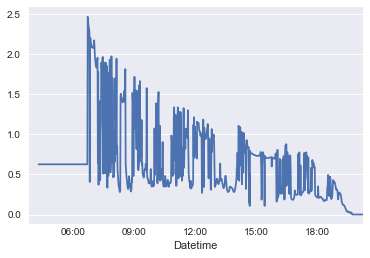

In [55]:
varrennes_data_ghi_scale_adjusted_0717_1.plot()

In [58]:
varrennes_data_ghi_scale_adjusted_0717_2.loc[(varrennes_data_ghi_scale_adjusted_0717_2 > upper_limit)]

Datetime
2014-07-17 04:15:00-04:00         inf
2014-07-17 04:17:00-04:00         inf
2014-07-17 04:18:00-04:00         inf
2014-07-17 04:19:00-04:00         inf
2014-07-17 04:20:00-04:00         inf
                               ...   
2014-07-17 06:37:00-04:00    2.546571
2014-07-17 06:38:00-04:00    2.583828
2014-07-17 06:39:00-04:00    2.567195
2014-07-17 06:40:00-04:00    2.551028
2014-07-17 06:41:00-04:00    2.543567
Length: 146, dtype: float64

#### Variance still changes. 

### In order to make a progress, come back to this issue later. 